**Names**: Tia (2205775), Bram Schork (2205684), Jacob Alderete (2206035)

# Imports

In [145]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Problem 1

## Part (a)

In [95]:
file_parsing = {
    "F-F_Momentum_Factor_CSV.zip": {
        "name": "mom_monthly",
        "header": 11,
        "nrows": 1176,
        "names": ["Date", "Mom"]
    },
    "F-F_Momentum_Factor_daily_CSV.zip": {
        "name": "mom_daily",
        "header": 11,
        "nrows": 25800,
        "names": ["Date", "Mom"]
    },
    "F-F_Research_Data_5_Factors_2x3_CSV.zip": {
        "name": "ff5_monthly",
        "header": 2,
        "nrows": 738,
        "names": ["Date", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
    },
    "F-F_Research_Data_5_Factors_2x3_daily_CSV.zip": {
        "name": "ff5_daily",
        "header": 2,
        "nrows": None,
        "names": ["Date", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
    }
}

datasets = {}

for zip_file, params in file_parsing.items():
    df = pd.read_csv(
        zip_file,
        header=params["header"],
        names=params["names"],
        nrows=params["nrows"]
    )

    # Convert Date column to datetime immediately
    if df["Date"].iloc[0] < 999999:  # Heuristic: YYYYMM format
        df["Date"] = pd.to_datetime(df["Date"].astype(str), 
                                    format="%Y%m").dt.to_period('M')
    else:  # For daily data in YYYYMMDD format
        df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y%m%d")

    datasets[params["name"]] = df

In [96]:
datasets["mom_monthly"]

,Date,Mom
0,1927-01,0.36
1,1927-02,-2.14
2,1927-03,3.61
3,1927-04,4.30
4,1927-05,3.00
...,...,...
1171,2024-08,4.79
1172,2024-09,-0.60
1173,2024-10,2.87
1174,2024-11,0.90


In [97]:
# Build combined daily & monthly factor tables
# daily: outer‐join on Date so any missing factor shows up as NaN
df_daily = pd.merge(
    datasets["ff5_daily"],
    datasets["mom_daily"][["Date", "Mom"]],
    on="Date",
    how="outer"
).sort_values("Date").set_index("Date")

# monthly: same as above
df_monthly = pd.merge(
    datasets["ff5_monthly"],
    datasets["mom_monthly"][["Date", "Mom"]],
    on="Date",
    how="outer"
).sort_values("Date").set_index("Date")

In [98]:
df_monthly

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom
Date,,,,,,,
1927-01,NaN,NaN,NaN,NaN,NaN,NaN,0.36
1927-02,NaN,NaN,NaN,NaN,NaN,NaN,-2.14
1927-03,NaN,NaN,NaN,NaN,NaN,NaN,3.61
1927-04,NaN,NaN,NaN,NaN,NaN,NaN,4.30
1927-05,NaN,NaN,NaN,NaN,NaN,NaN,3.00
...,...,...,...,...,...,...,...
2024-08,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79
2024-09,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60
2024-10,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87


In [99]:
df_daily

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom
Date,,,,,,,
1926-11-03,NaN,NaN,NaN,NaN,NaN,NaN,0.56
1926-11-04,NaN,NaN,NaN,NaN,NaN,NaN,-0.50
1926-11-05,NaN,NaN,NaN,NaN,NaN,NaN,1.17
1926-11-06,NaN,NaN,NaN,NaN,NaN,NaN,-0.03
1926-11-08,NaN,NaN,NaN,NaN,NaN,NaN,-0.01
...,...,...,...,...,...,...,...
2024-12-24,1.11,-0.12,-0.05,-0.13,-0.37,0.017,0.67
2024-12-26,0.02,1.09,-0.19,-0.44,0.35,0.017,0.01
2024-12-27,-1.17,-0.44,0.56,0.41,0.03,0.017,-0.88


## Part (b)

In [100]:
# compute rolling variance (window=22 days, require full 22 observations)
df_daily_var22 = df_daily.rolling(window=22, min_periods=22).var()

# if you’d like to keep them in the same frame, suffix the column names:
df_daily_var22.columns = [col + "_var22" for col in df_daily_var22.columns]

# and then concatenate
df_daily = pd.concat([df_daily, df_daily_var22], axis=1)

In [101]:
df_daily

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom,Mkt-RF_var22,SMB_var22,HML_var22,RMW_var22,CMA_var22,RF_var22,Mom_var22
Date,,,,,,,,,,,,,,
1926-11-03,NaN,NaN,NaN,NaN,NaN,NaN,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-04,NaN,NaN,NaN,NaN,NaN,NaN,-0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-05,NaN,NaN,NaN,NaN,NaN,NaN,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-06,NaN,NaN,NaN,NaN,NaN,NaN,-0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-08,NaN,NaN,NaN,NaN,NaN,NaN,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,1.11,-0.12,-0.05,-0.13,-0.37,0.017,0.67,0.807481,0.491921,0.279187,0.494185,0.208387,1.655844e-06,0.965847
2024-12-26,0.02,1.09,-0.19,-0.44,0.35,0.017,0.01,0.795482,0.452180,0.258875,0.479230,0.202073,1.402597e-06,0.956825
2024-12-27,-1.17,-0.44,0.56,0.41,0.03,0.017,-0.88,0.851588,0.349691,0.277311,0.486100,0.196355,1.110390e-06,0.909293


## Part (c)

In [102]:
# Collapse df_daily var columns to month-end
df_monthly_var22 = (
    df_daily
      .filter(like="_var22")             # pick out the var22 cols
      .resample("ME")                      # calendar month‐end
      .last()                             # last trading‐day var per month
      .to_period("M")                     # keep month and year only
)

# Merge the two tables on month
df_monthly_all = df_monthly.join(df_monthly_var22)

factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"]

# For each factor, regress var_t on lagged var (plus constant)
records = []
for factor in factors:
    factor_var = factor + "_var22"
    series = df_monthly_all[factor_var].dropna()
    # pull t and t−1
    df_reg = pd.DataFrame({
        "var_t": series,
        "var_t_1": series.shift(1)
    }).dropna() # drop NaN values
    
    X = sm.add_constant(df_reg["var_t_1"])
    model = sm.OLS(df_reg["var_t"], X).fit()
    
    records.append({
        "factor":          factor_var.replace("_var22",""),
        "coef_lag":        model.params["var_t_1"],
        "pvalue_lag":      model.pvalues["var_t_1"],
        "signif_5pct":     model.pvalues["var_t_1"] < 0.05
    })

summary_df = pd.DataFrame(records).set_index("factor")

In [103]:
summary_df

,coef_lag,pvalue_lag,signif_5pct
factor,,,
Mkt-RF,0.455271,5.353625e-39,True
SMB,0.368813,3.564584e-25,True
HML,0.746163,4.775988e-132,True
RMW,0.722323,1.237260e-119,True
CMA,0.688149,1.548166e-104,True
Mom,0.635900,3.773912e-134,True


**Yes**. For all of the risky factors (Mkt–RF, SMB, HML, RMW, CMA and Mom) the lag-variance coefficient is positive and highly significant (p-values << 0.05), so current variance does predict next month's variance.

## Part (d)

In [104]:
# For each factor, regress next month’s return on this month’s var22
records_partd = []
for factor in factors:
    factor_var = factor + "_var22"
    df_reg = pd.DataFrame({
        "ret_t1": df_monthly_all[factor],                # future return
        "var_t":  df_monthly_all[factor_var].shift(1)    # current variance
    }).dropna()                                          # drop any NaNs 

    X = sm.add_constant(df_reg["var_t"])
    model = sm.OLS(df_reg["ret_t1"], X).fit()

    records_partd.append({
        "factor":      factor,
        "coef_var":    model.params["var_t"],
        "pvalue_var":  model.pvalues["var_t"],
        "signif_5pct": model.pvalues["var_t"] < 0.05
    })

summary_df_partd = pd.DataFrame(records_partd).set_index("factor")

In [105]:
summary_df_partd

,coef_var,pvalue_var,signif_5pct
factor,,,
Mkt-RF,-0.007016,9.262857e-01,False
SMB,0.105143,6.451133e-01,False
HML,-0.105553,5.291985e-01,False
RMW,0.991033,2.783912e-04,True
CMA,1.403083,6.202527e-05,True
Mom,-0.621533,1.585757e-07,True


Variance carries no significant predictive power for Mkt–RF, SMB, or HML (all p-values > 0.5). However, higher RMW and CMA volatility predicts greater next-month returns (p < 0.001), while higher momentum volatility predicts lower future momentum returns (p < 0.001).

## Part (e)

In [106]:
# compute c_i = long‐run (sample) mean variance for each factor
c = df_monthly_all.filter(f + "_var22" for f in factors).mean()

# build weight series w_{i,t} = c_i / sigma_{i,t}^2  (here sigma^2 = our var22)
weights = c / df_monthly_all.filter(f + "_var22" for f in factors)

# shift weights by one month: w_{i,t-1}
w_lag = weights.shift(1).dropna() # drop NaN weights

# rename weight columns so they match your factor names
w_lag.columns = [col.replace("_var22", "") for col in w_lag.columns]

# compute volatility-managed returns: w_{i,t-1} * R_{i,t}
# .multiply() aligns on index and columns
df_vm = w_lag.multiply(
    df_monthly_all.filter(items=[f for f in factors])).dropna() 

# rename columns to indicate vol-managed
df_vm.columns = [f + "_vm" for f in df_vm.columns]
df_vm

,Mkt-RF_vm,SMB_vm,HML_vm,RMW_vm,CMA_vm,Mom_vm
Date,,,,,,
1963-08,23.494188,-11.360359,15.999648,2.563364,-1.568581,7.551417
1963-09,-18.719853,-4.594272,1.107102,-8.426587,1.778621,2.294551
1963-10,17.007489,-7.860621,-0.960593,15.372185,-10.152892,24.727927
1963-11,-5.142293,-3.377773,5.060059,-1.304268,3.706516,-4.515657
1963-12,1.269919,-3.006226,-0.084214,0.050958,-0.121279,1.575423
...,...,...,...,...,...,...
2024-08,1.994843,-0.637998,-0.378571,0.493635,0.369540,3.472945
2024-09,1.073044,-0.488459,-1.824588,0.023099,-0.112735,-0.761483
2024-10,-1.275691,-0.540291,0.653250,-1.383892,0.728873,3.599848


## Part (f)

In [ ]:
# Define the three models by their predictor lists
models = {
    "CAPM": ["Mkt-RF"],
    "FF3": ["Mkt-RF", "SMB", "HML"],
    "FF5+Mom": ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"]
}

records_partf = []
for col in df_vm.columns:              # i.e. "Mkt-RF_vm", "SMB_vm", ...
    factor = col.replace("_vm", "")
    for name, preds in models.items():
        # build regression table: vol-managed return and its predictors
        df_reg = pd.concat(
            [df_vm[col]] +
            [df_monthly[p] for p in preds],
            axis=1
        ).dropna()
        
        X = sm.add_constant(df_reg[preds])
        y = df_reg[col]
        res = sm.OLS(y, X).fit()
        
        records_partf.append({
            "factor": factor,
            "model": name,
            "alpha": res.params["const"],
            "pvalue_alpha": res.pvalues["const"],
            "signif_5pct": res.pvalues["const"] < 0.05
        })

alpha_summary = pd.DataFrame(records_partf).set_index(["factor", "model"])
alpha_summary

alpha  pvalue_alpha  signif_5pct
factor model                                       
Mkt-RF CAPM     0.489159  1.085271e-01        False
       FF3      0.462963  1.320307e-01        False
       FF5+Mom  0.075567  8.102905e-01        False
SMB    CAPM     0.131401  6.422386e-01        False
       FF3     -0.023801  9.100764e-01        False
       FF5+Mom -0.199699  3.589766e-01        False
HML    CAPM     1.123394  1.489803e-03         True
       FF3      0.415665  1.403872e-01        False
       FF5+Mom  0.780529  5.560307e-03         True
RMW    CAPM     0.874257  7.236082e-06         True
       FF3      1.025432  5.825360e-08         True
       FF5+Mom  0.589008  2.220986e-04         True
CMA    CAPM     0.525881  4.789172e-04         True
       FF3      0.295945  2.710813e-02         True
       FF5+Mom  0.206165  6.610711e-02        False
Mom    CAPM     3.924924  3.347800e-14         True
       FF3      4.104515  2.875791e-15         True
       FF5+Mom  2.710298  1.717412e-09         True

Under all three models, the RMW and Mom volatility-managed strategies earn positive and highly significant alpha (p < 0.001), while CMA earns significant alpha under CAPM and FF3 (but just misses significance in FF5+Mom, p~0.066). HML also produces significant alpha in the CAPM and FF5+Mom regressions (but not in FF3). By contrast, Mkt-RF and SMB show no significant alpha in any specification.

Even though variance positively predicts future variance, scaling each factor by lagged volatility can still harvest time-varying risk premia. When variance is low, the strategy ramps up exposure to that factor's expected premium; when variance is high, it scales back. This volatility timing boosts risk-adjusted returns—in effect buying low when conditional variance (and hence risk) is low and selling high when risk is elevated, yielding net alpha even in factors whose variance itself is persistent.

# Problem 2

## Part (a)

In [126]:
# build var & return panels
var_df = df_monthly_var22[[f + "_var22" for f in factors]]

# inverse-variance weights each month
inv_var = 1.0 / var_df # 1/sigma^2
w = inv_var.div(inv_var.sum(axis=1), axis=0).dropna() # normalize: sum of w = 1
w.columns = factors # drop the "_var22" suffix

# apply the hint from part (e): lag the weights by one month
w_lag = w.shift(1).dropna()
w_lag


,Mkt-RF,SMB,HML,RMW,CMA,Mom
Date,,,,,,
1963-08,0.026554,0.283737,0.156820,0.268094,0.187691,0.077103
1963-09,0.055850,0.144301,0.122815,0.365272,0.209959,0.101801
1963-10,0.046921,0.137634,0.206431,0.251784,0.257674,0.099556
1963-11,0.088687,0.196203,0.130505,0.246332,0.177283,0.160990
1963-12,0.015738,0.113206,0.294017,0.253118,0.287177,0.036744
...,...,...,...,...,...,...
2024-08,0.111213,0.054706,0.092582,0.342501,0.281880,0.117118
2024-09,0.045005,0.121859,0.158287,0.276904,0.231263,0.166682
2024-10,0.066644,0.108484,0.114515,0.333895,0.262076,0.114387


In [150]:
# build the matrix of w_{i,t-1} * R_{i,t} and drop any all-NA rows, then sum 
# across factor‐columns to get the single vol-managed portfolio return
vm_port = w_lag.multiply(df_monthly_all[factors]).dropna().sum(axis=1)
vm_port.name = "vm_ret"
vm_port

Date
1963-08    0.298613
1963-09   -0.325869
1963-10    0.404444
1963-11    0.132693
1963-12   -0.163020
             ...   
2024-08    0.969295
2024-09   -0.605011
2024-10    0.079261
2024-11   -0.355390
2024-12   -0.546671
Freq: M, Name: vm_ret, Length: 737, dtype: float64

## Part (b)

In [144]:
records_partb = []
for name, preds in models.items():
    # align VM returns and the predictors, drop any months with missing data
    df_reg = pd.concat(
        [vm_port] +
        [df_monthly[p] for p in preds],
        axis=1
    ).dropna()
    
    # regress VM returns on the chosen factors
    X = sm.add_constant(df_reg[preds])
    y = df_reg["vm_ret"]
    res = sm.OLS(y, X).fit()
    
    records_partb.append({
        "model": name,
        "alpha": res.params["const"],
        "pvalue_alpha": res.pvalues["const"],
        "signif_5pct": res.pvalues["const"] < 0.05
    })

alpha_vm = pd.DataFrame(records_partb).set_index("model")
alpha_vm

,alpha,pvalue_alpha,signif_5pct
model,,,
CAPM,0.328980,8.750218e-17,True
FF3,0.249655,1.290598e-15,True
FF5+Mom,0.075478,5.743551e-04,True


The fully-aggregated VM portfolio delivers a positive, highly significant alpha in every specification: about 0.33% under CAPM (p~10^-16), 0.25% under FF3 (p~10^-15), and 0.08% under FF5+Mom (p~0.0005). Even after controlling for all five Fama-French factors plus momentum, the multi-factor strategy still earns a statistically meaningful excess return, outperforming each single-factor VM tilt.

## Part (c)

In [147]:
df_monthly_all

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom,Mkt-RF_var22,SMB_var22,HML_var22,RMW_var22,CMA_var22,RF_var22,Mom_var22
Date,,,,,,,,,,,,,,
1927-01,NaN,NaN,NaN,NaN,NaN,NaN,0.36,NaN,NaN,NaN,NaN,NaN,NaN,0.153899
1927-02,NaN,NaN,NaN,NaN,NaN,NaN,-2.14,NaN,NaN,NaN,NaN,NaN,NaN,0.126329
1927-03,NaN,NaN,NaN,NaN,NaN,NaN,3.61,NaN,NaN,NaN,NaN,NaN,NaN,0.205204
1927-04,NaN,NaN,NaN,NaN,NaN,NaN,4.30,NaN,NaN,NaN,NaN,NaN,NaN,0.211921
1927-05,NaN,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,0.239990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79,1.681124,0.620879,0.477990,0.273233,0.327158,0.000000e+00,0.453913
2024-09,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60,0.788305,0.484273,0.458769,0.157342,0.200460,3.463203e-07,0.459282
2024-10,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87,0.474499,0.454578,0.444879,0.152521,0.113003,0.000000e+00,0.281870


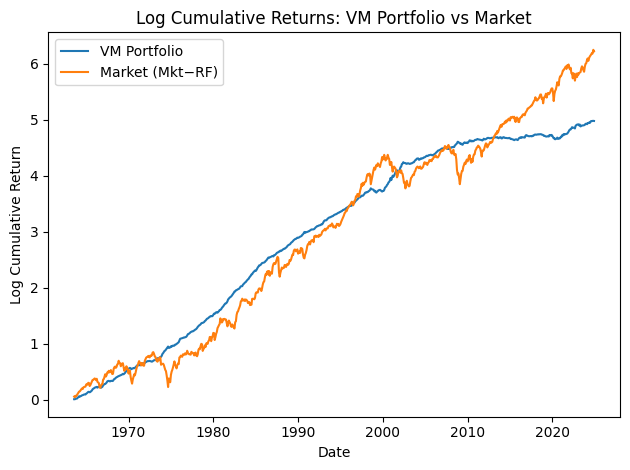

In [151]:
# limit df_monthly_all to dates in vm_port
returns_aligned = df_monthly_all.loc[vm_port.index, ['RF', 'Mkt-RF']]

# Align and convert the PeriodIndex to Timestamps for matplotlib
dates = vm_port.index.to_timestamp()

# Compute log cumulative returns
cum_log_vm = np.log(((vm_port + returns_aligned['RF']) / 100 + 1.0).cumprod())
cum_log_mkt = np.log(((returns_aligned['Mkt-RF'] + returns_aligned['RF']) / 100 + 1.0).cumprod())

# Plot
plt.figure()
plt.plot(dates, cum_log_vm, label='VM Portfolio')
plt.plot(dates, cum_log_mkt, label='Market (Mkt−RF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Cumulative Return')
plt.title('Log Cumulative Returns: VM Portfolio vs Market')
plt.tight_layout()
plt.show()

Although the VM portfolio earned a smoother, more steadily rising growth path from the 1960s through the 1990s, it has flattened out relative to the market since 2000. In raw cumulative terms the market has gone on to outpace the volatility-managed strategy over the last two decades.

Yet the VM strategy still produces a significant positive alpha in a factor regression because it systematically tilts into each factor when its conditional variance is low and tilts out when variance is high. That timing harvests extra risk premia on average, even though the compounded dollar-growth of the VM portfolio lagged the simple market buy-and-hold after 2000, so that on a risk-adjusted (alpha) basis it still outperforms.